In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pprint

In [25]:
#
city_num = 20
#
tag = '.pr5'
SUF = '.gl5'
dtype = 'float32'
gl5shape = (2160, 4320)
#
h08dir = '/home/kajiyama/H08/H08_20230612'
#
rivnum_path = h08dir + '/map/out/riv_num_/rivnum.CAMA' + SUF
maskpath = h08dir + '/map/dat/lnd_msk_/lndmask.CAMA.gl5'
ctymsk_path = h08dir + f'/map/dat/cty_msk_/city_{city_num:08}.gl5'

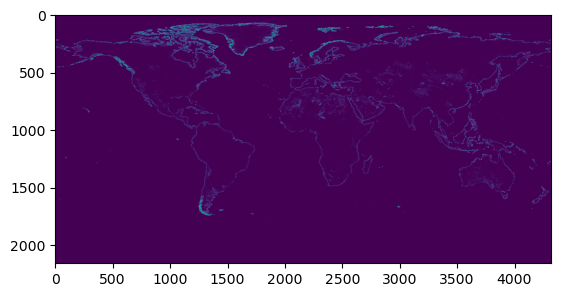

In [3]:
rivnum = np.fromfile(rivnum_path, dtype=dtype)
rivnum_lonlat = rivnum.reshape(gl5shape)
plt.imshow(rivnum_lonlat)

456 528 2160 2232


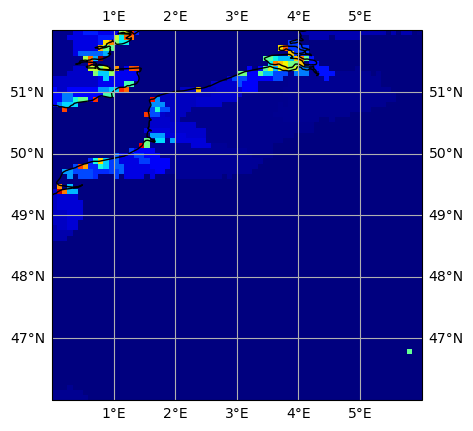

In [19]:
# london region
left = 0
right = 6
bottom = 46
top = 52
upperindex = (90-top)*12
lowerindex = (90-bottom)*12
leftindex = (180+left)*12
rightindex = (180+right)*12
print(upperindex, lowerindex, leftindex, rightindex)
#
rivnum_cropped = rivnum_lonlat[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
#
projection = ccrs.PlateCarree(central_longitude=0)
img_extent = (left, right, bottom, top)
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)
im = ax.imshow(rivnum_cropped, extent=img_extent, transform=projection, cmap='jet')

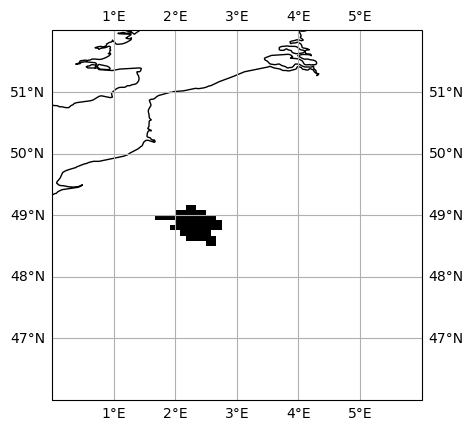

In [20]:
#
citymask = np.fromfile(ctymsk_path, dtype=dtype).reshape(gl5shape)
citymask_cropped = citymask[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
#
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)
im = ax.imshow(citymask_cropped, extent=img_extent, transform=projection, cmap='gray_r')

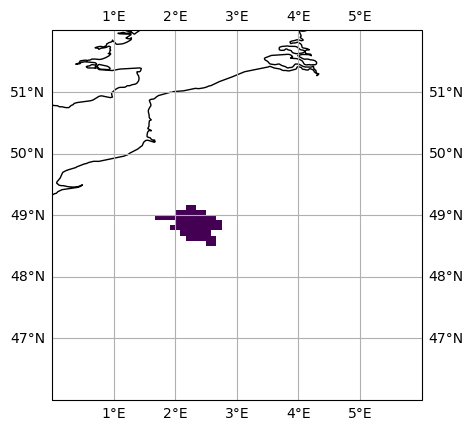

In [21]:
rivnum_london = np.where(citymask_cropped == 1, rivnum_cropped, np.nan)
rivnum_london = np.ma.masked_where(~np.isfinite(rivnum_london) |  (rivnum_london == 0), rivnum_london)
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)
im = ax.imshow(rivnum_london, extent=img_extent, transform=projection)

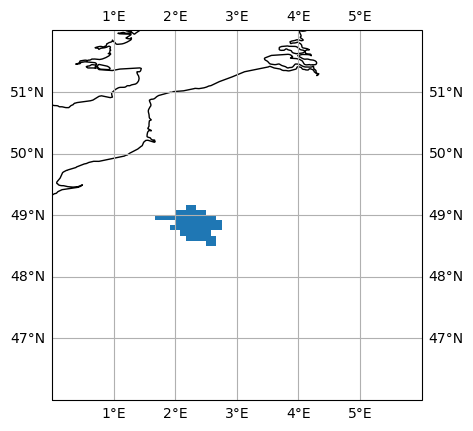

In [22]:
remove_basin_grid_threshold = 1
#
rivnum_cropped_masked = np.ma.masked_array(rivnum_cropped, np.isnan(rivnum_cropped))
unique_values, counts = np.unique(rivnum_cropped_masked.compressed(), return_counts=True)
value_counts_dict = dict(zip(unique_values, counts))
sorted_dict_by_value_descending = dict(sorted(value_counts_dict.items(), key=lambda item: item[1], reverse=True))
filtered_dict = {key: value for key, value in sorted_dict_by_value_descending.items() if value >= remove_basin_grid_threshold}
#
rivnum_london_removed = np.ma.masked_all(rivnum_cropped.shape, dtype=dtype)
for rivnum_id in filtered_dict.keys():
    matching_positions = np.where(rivnum_london.data == rivnum_id)
    rivnum_london_removed[matching_positions] = rivnum_id
#
rivnum_london_removed = np.ma.masked_where(~np.isfinite(rivnum_london_removed) | (rivnum_london_removed == 0), rivnum_london_removed)
#
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)
im = ax.imshow(rivnum_london_removed, extent=img_extent, transform=projection, cmap='tab20')

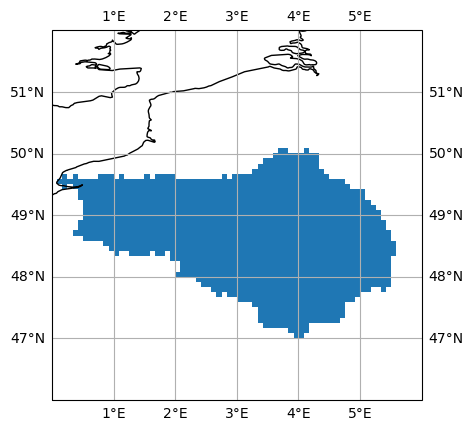

In [23]:
#
unique_ids = np.unique(rivnum_london_removed.compressed())
rivnum_unique = np.ma.masked_all(rivnum_cropped_masked.shape, dtype='float32')
for uid in unique_ids:
    row_indices, col_indices = np.where(rivnum_cropped == uid)
    rivnum_unique[row_indices, col_indices] = uid
#
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)
im = ax.imshow(rivnum_unique, extent=img_extent, transform=projection, cmap='tab20')

(72, 72)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


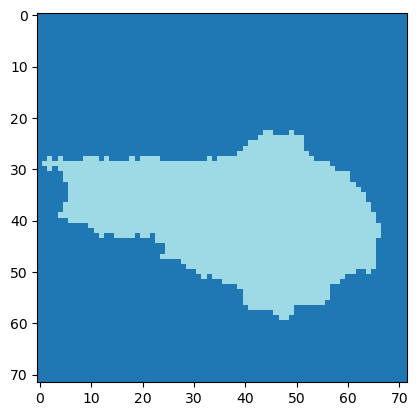

In [24]:
# 0-1 binary land mask file for only 5basins
rivnum_unique_filled = rivnum_unique.filled(0)
landmask = np.where(rivnum_unique_filled > 0, 1, 0)
print(landmask.shape)
print(landmask[0])
plt.imshow(landmask, cmap='tab20')

In [26]:
# save the file
save_flag = False
if save_flag is True:
    landmask.astype(np.float32).tofile(f"{h08dir}/map/dat/lnd_msk_/lndmsk.CAMA{tag}")